In [1]:
import pickle

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
ts = dict(rest=dict(), nback=dict(), emoid=dict())

for task in ['rest', 'nback', 'emoid']:
    tsgood = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    ts[task] = tsgood
    
print('Complete')

Complete


In [2]:
import numpy as np
import scipy.signal as sig

# Example
# From https://dsp.stackexchange.com/questions/25165/phase-locking-value-phase-synchronization
def hilphase(y1,y2):
    sig1_hill=sig.hilbert(y1)
    sig2_hill=sig.hilbert(y2)
    pdt=(np.inner(sig1_hill,np.conj(sig2_hill))/(np.sqrt(np.inner(sig1_hill,
               np.conj(sig1_hill))*np.inner(sig2_hill,np.conj(sig2_hill)))))
    phase = np.angle(pdt)
    
def butter_bandpass(cutoff, fs, order=5):
    normal_cutoff = [cutoff[0], cutoff[1]]
    b, a = sig.butter(order, normal_cutoff, btype='band', analog=False, fs=fs)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

tr = 3
    
def plv(ts):
    h = sig.hilbert(ts)
    hc = np.conj(h)
    a = np.inner(h,hc)
    b = np.mean(np.abs(h*hc), axis=-1)
    c = np.outer(b,b)
    return np.angle(a/c)

a,b = np.triu_indices(264,1)
ps = dict()

for key,val in ts['emoid'].items():
#     filt = butter_bandpass_filter(val, [0.01, 0.15], 1/tr)
    test = plv(val)
    ps[key] = test[a,b]
    
print(ps[key].shape)

(34716,)


In [16]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


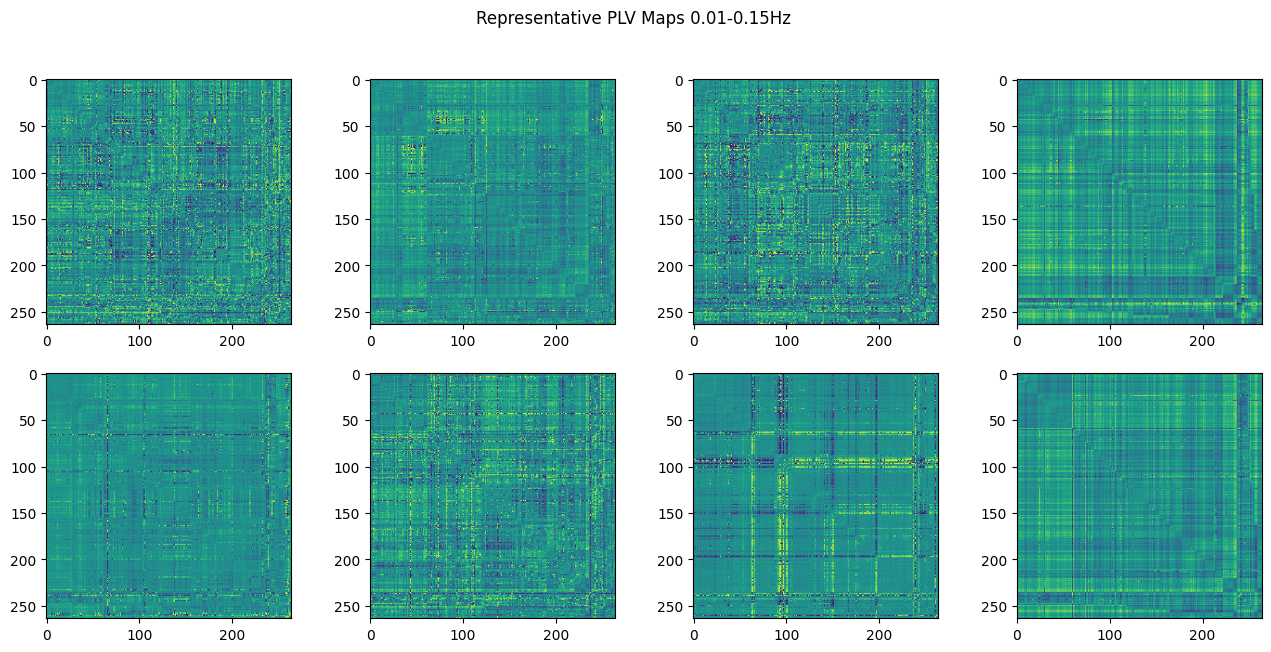

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(vec2mat(psvec[i*4+j])))
        
fig.suptitle('Representative PLV Maps 0.01-0.15Hz')
fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/PLVExample.pdf')
fig.show()

In [14]:
# Bring in (new) PNC cohort

import pickle
from pathlib import Path
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC'
tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

age = []
sex = []
race = []
psvec = []
fc = []

a,b = np.triu_indices(264,1)
i = 0

for task in ['rest', 'nback', 'emoid']:
    tsgood = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    for key in demo['age_at_cnb']:
        if key not in demo['Race'] or demo['Race'][key] not in ['AA', 'EA']:
            continue
        aa = demo['age_at_cnb'][key]
        ss = demo['Sex'][key] == 'M'
        rr = demo['Race'][key] == 'AA'
        try:
            p = np.load(f'{demodir}/fc/{key}_task-{task}_fc.npy')
        except:
            continue
        val = plv(tsgood[key])[a,b]
        fc.append(p)
        age.append(aa)
        sex.append(ss)
        race.append(rr)
        psvec.append(val)
        i += 1
        if i % 50 == 0:
            print(f'Done {i}')
    
psvec = np.stack(psvec)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
fc = np.stack(fc)

print([a.shape for a in [psvec, age, sex, race, fc]])

Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Done 600
Done 650
Done 700
Done 750
Done 800
Done 850
Done 900
Done 950
Done 1000
Done 1050
Done 1100
Done 1150
Done 1200
Done 1250
Done 1300
Done 1350
Done 1400
Done 1450
Done 1500
Done 1550
Done 1600
Done 1650
Done 1700
Done 1750
Done 1800
Done 1850
Done 1900
Done 1950
Done 2000
Done 2050
Done 2100
Done 2150
Done 2200
Done 2250
Done 2300
Done 2350
Done 2400
Done 2450
Done 2500
Done 2550
Done 2600
Done 2650
Done 2700
Done 2750
Done 2800
Done 2850
Done 2900
Done 2950
Done 3000
Done 3050
Done 3100
Done 3150
Done 3200
Done 3250
Done 3300
Done 3350
Done 3400
Done 3450
Done 3500
Done 3550
Done 3600
Done 3650
Done 3700
Done 3750
Done 3800
[(3849, 34716), (3849,), (3849,), (3849,), (3849, 34716)]


In [30]:
import sys

pth = '../../LatentSimilarity/'

if pth not in sys.path:
    sys.path.append(pth)
    
print(sys.path)

['/home/anton/Documents/Tulane/Research/code/AngleBasis', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/anton/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '../../LatentSimilarity/']


In [35]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from latsim import LatSimClf

def rmse(yhat, yt):
    if isinstance(yhat, np.ndarray):
        return np.mean((yhat-yt)**2)**0.5
    
accs = []

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(psvec, race, stratify=race, train_size=0.8)
    
#     ytr = ytr - np.mean(ytr)
#     yt = yt - np.mean(yt)

#     reg = Ridge(alpha=1).fit(xtr, ytr)
#     yhat = reg.predict(xt)

    reg = LatSimClf(nepochs=1000).fit(xtr, ytr)
    p = reg.predict_proba(xt)
    
#     acc = rmse(yhat, yt)
    acc = roc_auc_score(yt, p[:,1])
    print(acc)
    accs.append(acc)
    
print('---')
print(np.mean(accs), np.std(accs))

0.6560168918918919
0.7406587837837838
0.6929797297297298
0.7102466216216217
0.7073952702702703
0.6891993243243244
0.7356790540540541
0.6500067567567567
0.7566925675675675
0.7096452702702702
---
0.704852027027027 0.03279824480947383


In [36]:
np.mean(race)

0.4811639386853728